In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wrangle_zillow
from matplotlib import style
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import evaluate
style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from sklearn.feature_selection import RFE

In [2]:
# lets get the data
df = wrangle_zillow.wrangle_zillow(use_cache=False)

Reading from csv...
Saving to csv in local directory...


In [3]:
#print basic info
wrangle_zillow.basic_info(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19709 entries, 8 to 77573
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   19709 non-null  float64
 1   bedroomcnt                    19709 non-null  float64
 2   buildingqualitytypeid         19709 non-null  float64
 3   calculatedfinishedsquarefeet  19709 non-null  float64
 4   heatingorsystemtypeid         19709 non-null  float64
 5   latitude                      19709 non-null  float64
 6   longitude                     19709 non-null  float64
 7   lotsizesquarefeet             19709 non-null  float64
 8   rawcensustractandblock        19709 non-null  float64
 9   regionidcity                  19709 non-null  float64
 10  regionidzip                   19709 non-null  float64
 11  structuretaxvaluedollarcnt    19709 non-null  float64
 12  taxvaluedollarcnt             19709 non-null  float64
 13  l

In [4]:
# df where dtypes are object
df_obj = df.select_dtypes(include=['object'])
cols = df_obj.columns
#get number of unique values in each column
for col in cols:
    print(col, len(df_obj[col].unique()))

In [5]:
df.head()

bathroomcnt  bedroomcnt  buildingqualitytypeid  \
8           3.0         4.0                    9.0   
10          3.0         4.0                    8.0   
18          1.0         2.0                    4.0   
25          1.0         3.0                    4.0   
27          2.0         3.0                    6.0   

    calculatedfinishedsquarefeet  heatingorsystemtypeid    latitude  \
8                         3039.0                    2.0  33960230.0   
10                        2540.0                    2.0  34434971.0   
18                        1146.0                    7.0  34024040.0   
25                        1641.0                    7.0  33760954.0   
27                        1538.0                    2.0  34375142.0   

      longitude  lotsizesquarefeet  rawcensustractandblock  regionidcity  ...  \
8  -118006914.0            20028.0            6.037500e+07       14634.0  ...   
10 -118464390.0            10384.0            6.037920e+07       54311.0  ...   
18 -118159090.0             4657.0            6.037532e+07       17882.0  ...   
25 -118123592.0             5302.0            6.037578e+07       46298.0  ...   
27 -118559779.0             5997.0            6.037920e+07       54311.0  ...   

    q4 transactiondate  0101  0102  0103  0104  0108  010G  010M  0131   age  
8                    0     0     0     0     0     0     0     0     0  47.0  
10                   0     1     0     0     0     0     0     0     0  18.0  
18                   0     0     0     0     0     0     0     0     0  78.0  
25                   0     0     0     0     0     0     0     0     0  73.0  
27                   0     0     0     0     0     0     0     0     0  45.0  

[5 rows x 28 columns]

In [6]:
df.shape

(19709, 28)

In [7]:
# which columns have only one value?
df.nunique()[df.nunique() == 1]


Series([], dtype: int64)

In [8]:
#split into train, validation, and test
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_zillow.split_data(df)

In [9]:
train.logerror.describe()

count    11036.000000
mean         0.003264
std          0.049097
min         -0.129498
25%         -0.025970
50%          0.003839
75%          0.031661
max          0.139575
Name: logerror, dtype: float64

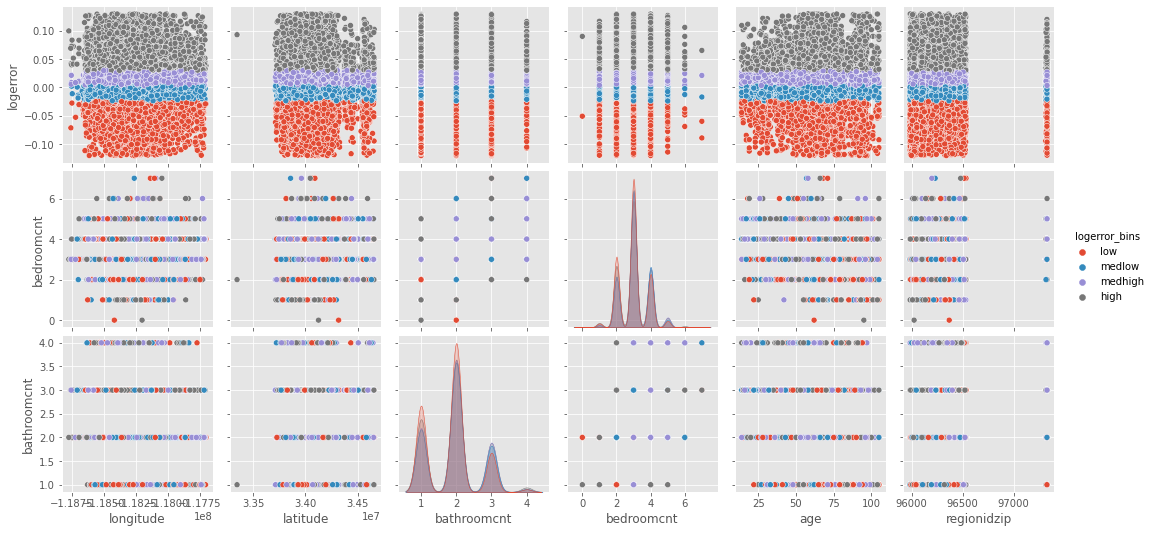

In [10]:
# make bins for log error in train data
train['logerror_bins'] = pd.cut(train['logerror'], bins=[-.12, -.024, .0036 ,0.03, .13], labels=['low', 'medlow','medhigh', 'high'])
sns.pairplot(data=train, hue= 'logerror_bins', y_vars=['logerror', 'bedroomcnt', 'bathroomcnt'],
 x_vars=['longitude', 'latitude', 'bathroomcnt', 'bedroomcnt',  'age', 'regionidzip'])

In [11]:
#scale the data using wrangle_zillow.scale_data
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle_zillow.scale_numeric_columns(X_train, X_validate, X_test)
X_train_scaled.head()



bathroomcnt  bedroomcnt  buildingqualitytypeid  \
55308     0.000000    0.285714                  0.125   
48643     0.666667    0.571429                  0.625   
20314     0.666667    0.428571                  0.625   
11875     0.666667    0.571429                  0.625   
76160     0.666667    0.571429                  0.500   

       calculatedfinishedsquarefeet  heatingorsystemtypeid  latitude  \
55308                      0.229302                    1.0  0.572848   
48643                      0.503960                    0.0  0.415558   
20314                      0.531317                    0.0  0.459331   
11875                      0.919006                    0.0  0.603505   
76160                      0.948524                    0.0  0.774516   

       longitude  lotsizesquarefeet  rawcensustractandblock  regionidcity  \
55308   0.824037           0.345566                0.346894      0.389461   
48643   0.662806           0.217697                0.513693      0.941001   
20314   0.552278           0.088035                0.494921      0.830772   
11875   0.880551           0.475477                0.340527      0.152658   
76160   0.214335           0.450978                0.932062      0.953668   

       ...  q4 transactiondate  0101  0102  0103  0104  0108  010G  010M  \
55308  ...                   1     0     0     0     0     0     0     0   
48643  ...                   0     0     0     0     0     0     0     0   
20314  ...                   0     0     0     0     0     0     0     0   
11875  ...                   0     1     0     0     0     0     0     0   
76160  ...                   1     0     0     0     0     0     0     0   

       0131       age  
55308     0  0.527473  
48643     0  0.472527  
20314     0  0.098901  
11875     0  0.483516  
76160     0  0.164835  

[5 rows x 27 columns]

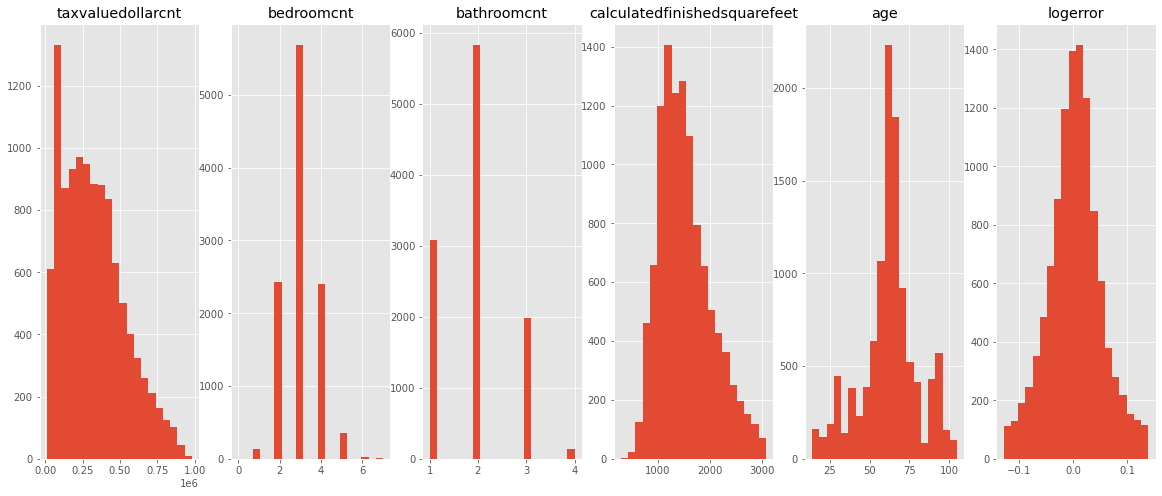

In [12]:
evaluate.histograms_of_data(train)

In [13]:
#get numerical columns
cols = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]
cols.remove('logerror')
#number of cols
ncols = len(cols)
int(ncols/5), ncols%5, ncols


(3, 2, 17)

In [14]:
def graph_variables_vs_target(df, target = 'logerror'):
    """This function will graph the variables vs the target"""
    # lets look at the relationship between the target variable and the other variables
    # lets change figure size
    plt.rcParams["figure.figsize"] = (20, 8)
    # pick the columns to plot
    cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
    #number of cols
    ncols = len(cols)
    # plt.subplot(row X col, where?)
    fig, axes = plt.subplots(int(ncols/4)+1, 4, sharey=True)
    # run throught the columns and plot the distribution
    for i, col in enumerate(cols):
        x = i%4
        y = int(i/4)
        # Title with column name.
        axes[y,x].set_title(col)
        # Display lmplot for column.
        sns.regplot(
            data=df, x=col, y=target, line_kws={"color": "blue"}, ax=axes[y,x],
        )

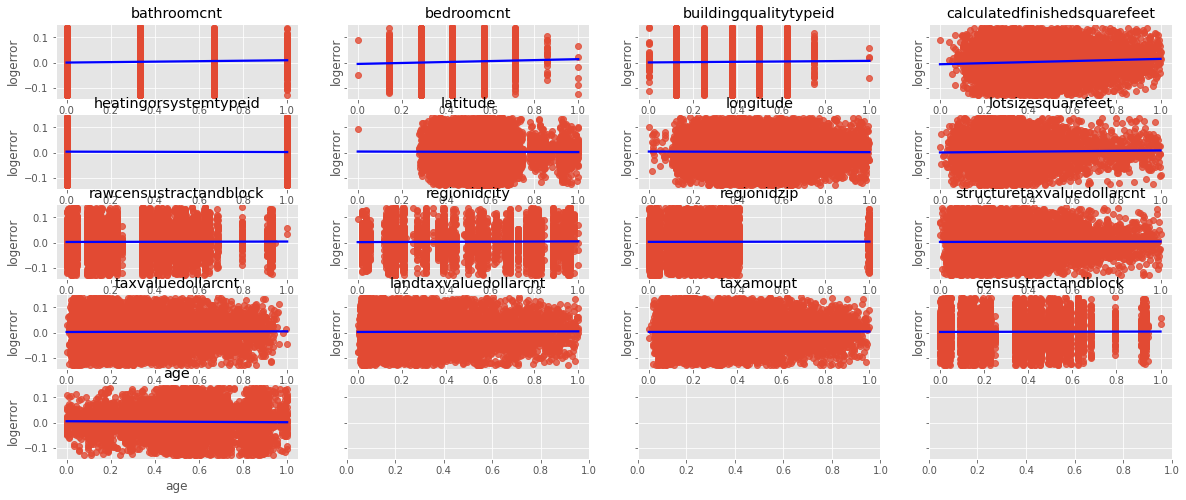

In [15]:
graph_variables_vs_target(X_train_scaled, train['logerror'])

In [16]:
def elbow_graph(df):
    '''make and elbow graph to determine a good k'''
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(9, 6))
        pd.Series({k: KMeans(k).fit(subset).inertia_ for k in range(2, 12)}).plot(marker='x')
        plt.xticks(range(2, 12))
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Change in inertia as k increases')

In [17]:
X_train_scaled['logerror_bins'] = pd.cut(train['logerror'], bins=[-.12, -.024, .0036 ,0.03, .13], labels=['low', 'medlow','medhigh', 'high'])


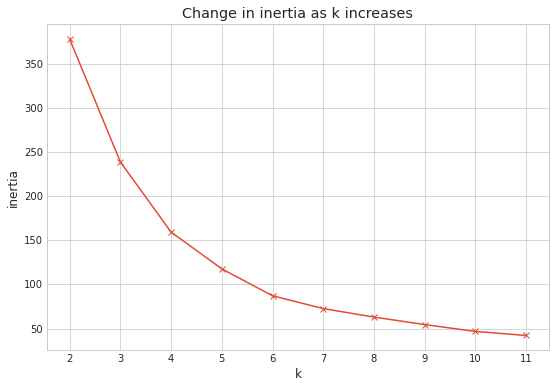

In [18]:
# lets determine a good k using a subset of x_train_scaled
subset = X_train_scaled[["latitude","longitude"]]
elbow_graph(subset)

In [19]:
def cluster(df, k, cluster_num):
    '''cluster the data using kmeans'''
    columns = df.columns.to_list()
    cluster_num = 'cluster_num'+str(cluster_num)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df)
    kmeans.predict(df)
    cols = df.columns.to_list()
    X_train_scaled[cluster_num] = kmeans.predict(df)
    X_train_scaled[cluster_num]= X_train_scaled[cluster_num].astype('category')
    X_validate_scaled[cluster_num] = kmeans.predict(X_validate_scaled[columns])
    X_test_scaled[cluster_num] = kmeans.predict(X_test_scaled[columns])
    rel = sns.relplot(x=cols[0], y=cols[1], hue=cluster_num, data=X_train_scaled, col='logerror_bins')
    rel.fig.suptitle('scaled with k = {}'.format(k))

In [20]:
X_train_scaled.head()

bathroomcnt  bedroomcnt  buildingqualitytypeid  \
55308     0.000000    0.285714                  0.125   
48643     0.666667    0.571429                  0.625   
20314     0.666667    0.428571                  0.625   
11875     0.666667    0.571429                  0.625   
76160     0.666667    0.571429                  0.500   

       calculatedfinishedsquarefeet  heatingorsystemtypeid  latitude  \
55308                      0.229302                    1.0  0.572848   
48643                      0.503960                    0.0  0.415558   
20314                      0.531317                    0.0  0.459331   
11875                      0.919006                    0.0  0.603505   
76160                      0.948524                    0.0  0.774516   

       longitude  lotsizesquarefeet  rawcensustractandblock  regionidcity  \
55308   0.824037           0.345566                0.346894      0.389461   
48643   0.662806           0.217697                0.513693      0.941001   
20314   0.552278           0.088035                0.494921      0.830772   
11875   0.880551           0.475477                0.340527      0.152658   
76160   0.214335           0.450978                0.932062      0.953668   

       ...  0101  0102  0103  0104  0108  010G  010M  0131       age  \
55308  ...     0     0     0     0     0     0     0     0  0.527473   
48643  ...     0     0     0     0     0     0     0     0  0.472527   
20314  ...     0     0     0     0     0     0     0     0  0.098901   
11875  ...     1     0     0     0     0     0     0     0  0.483516   
76160  ...     0     0     0     0     0     0     0     0  0.164835   

       logerror_bins  
55308           high  
48643         medlow  
20314        medhigh  
11875        medhigh  
76160         medlow  

[5 rows x 28 columns]

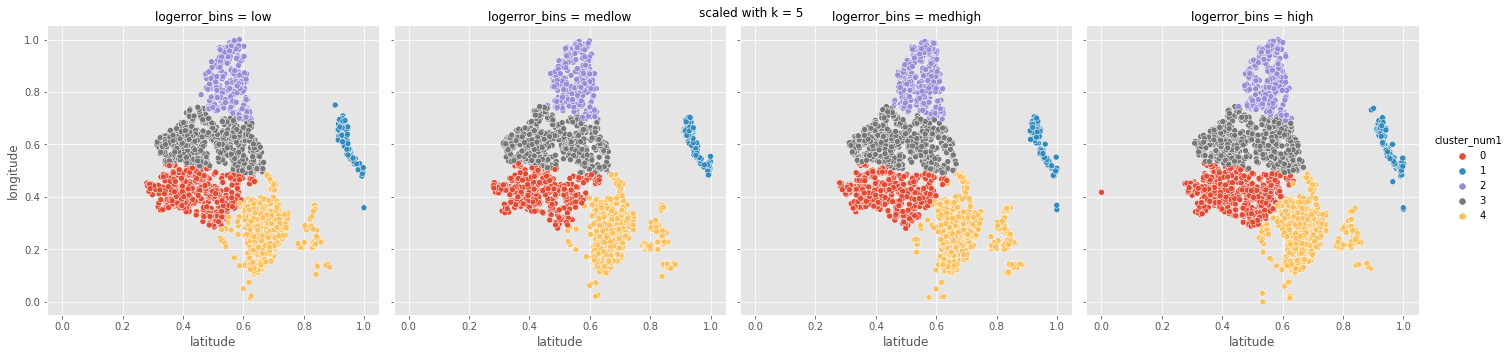

In [21]:
# use the k determined above
subset = X_train_scaled[["latitude","longitude"]]
cluster(subset, 5, 1)

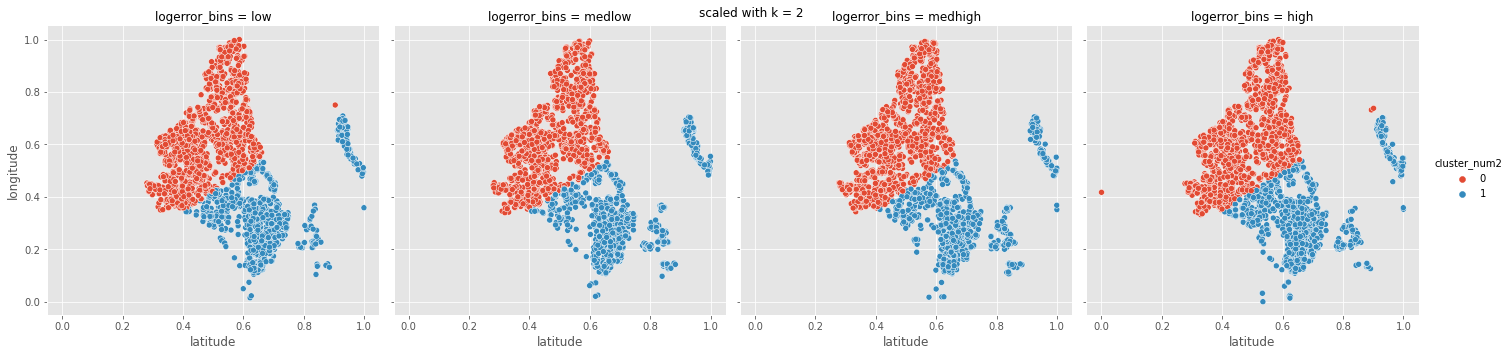

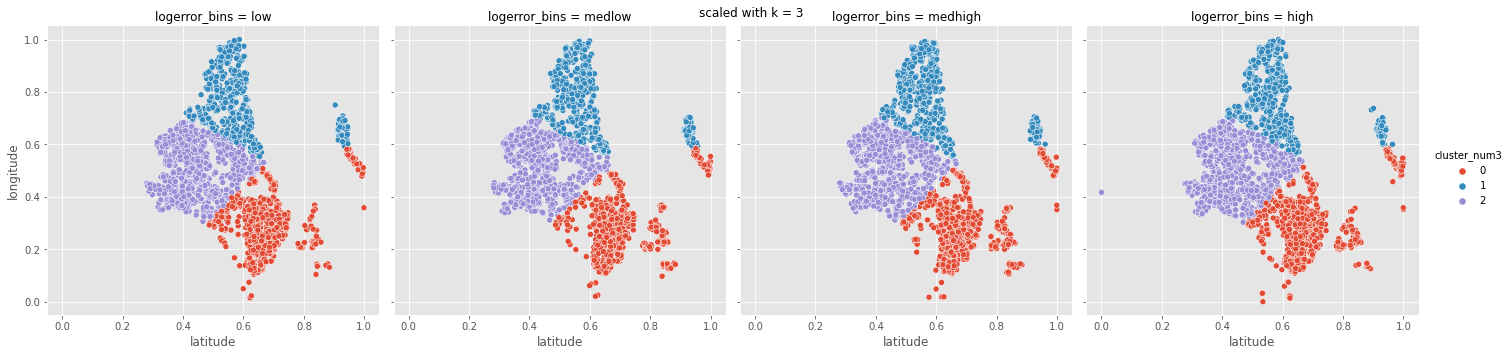

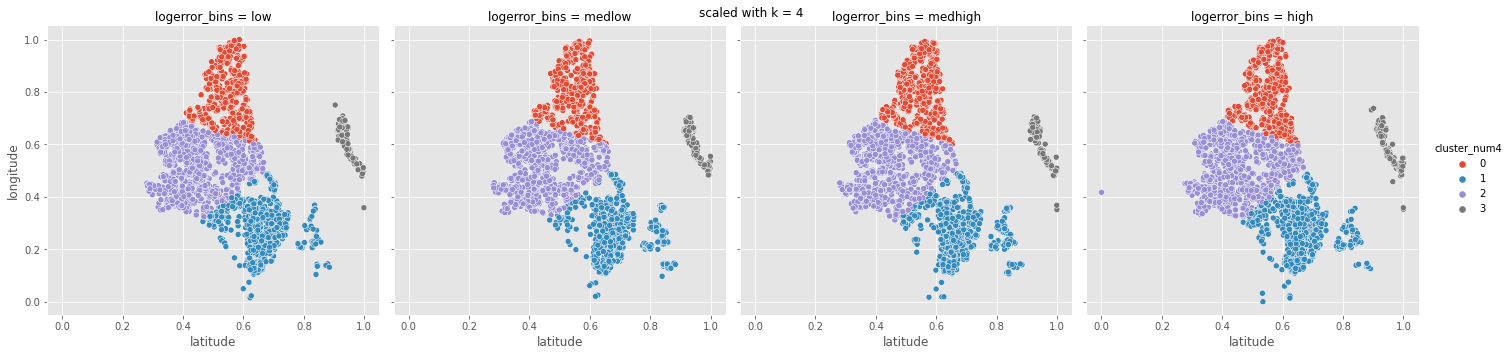

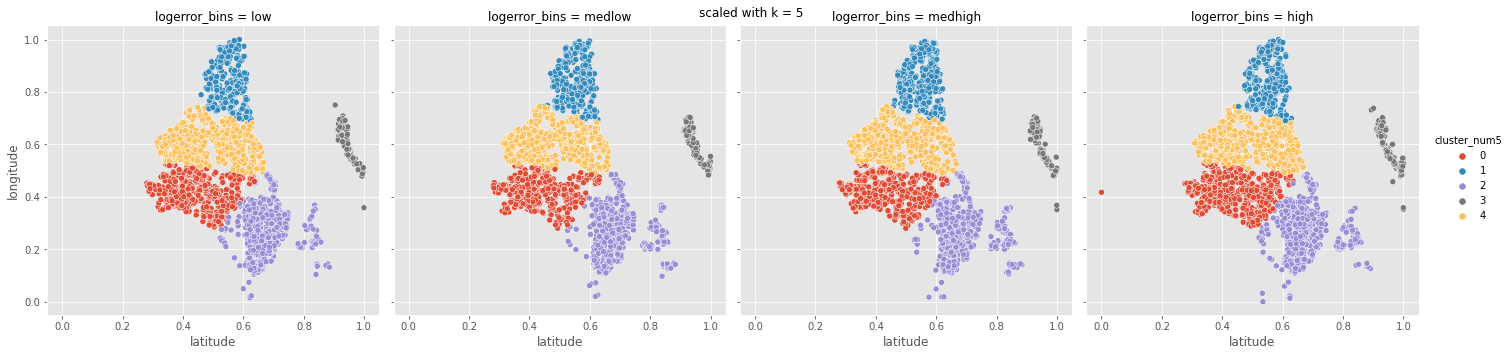

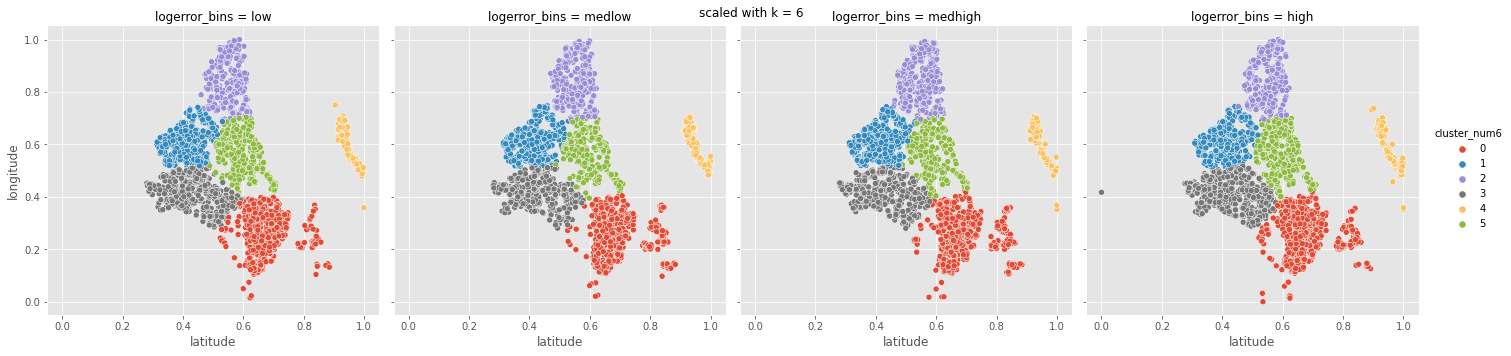

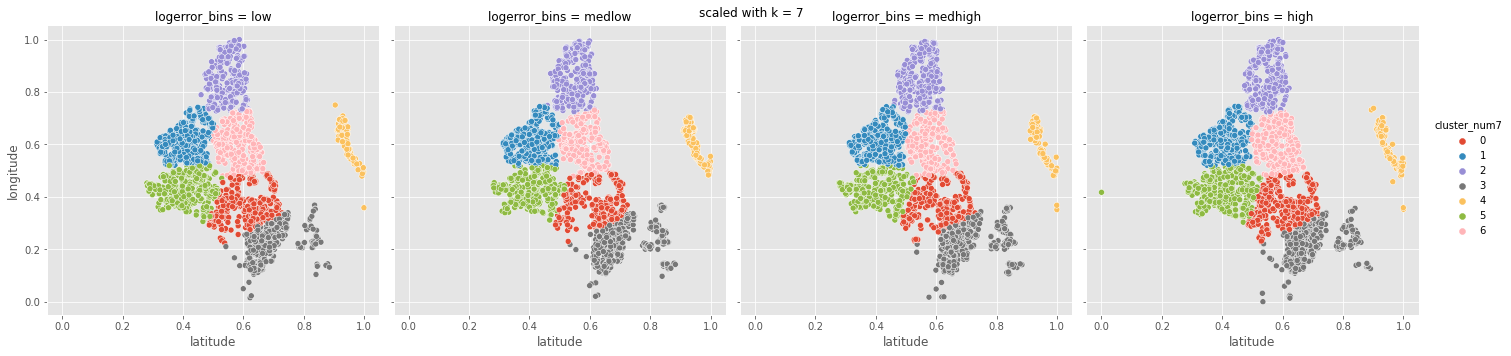

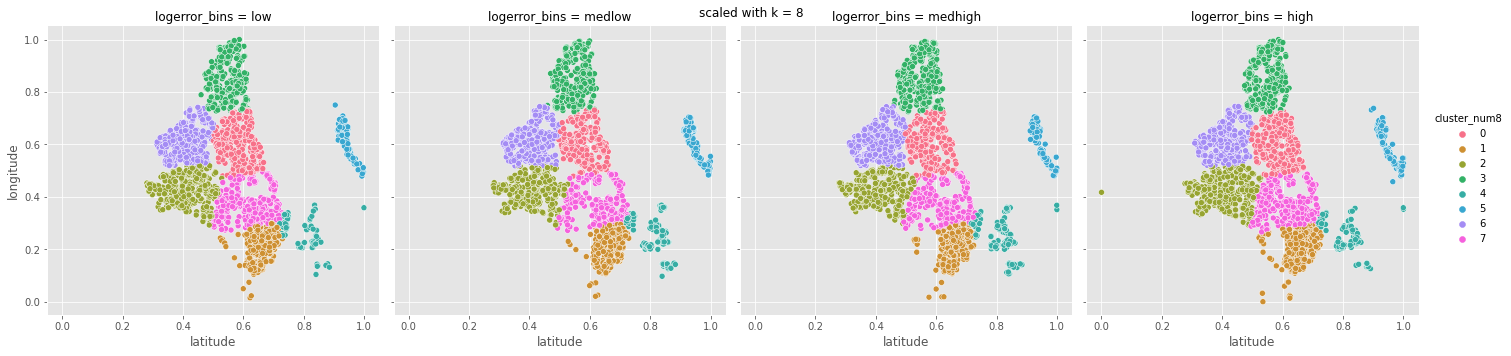

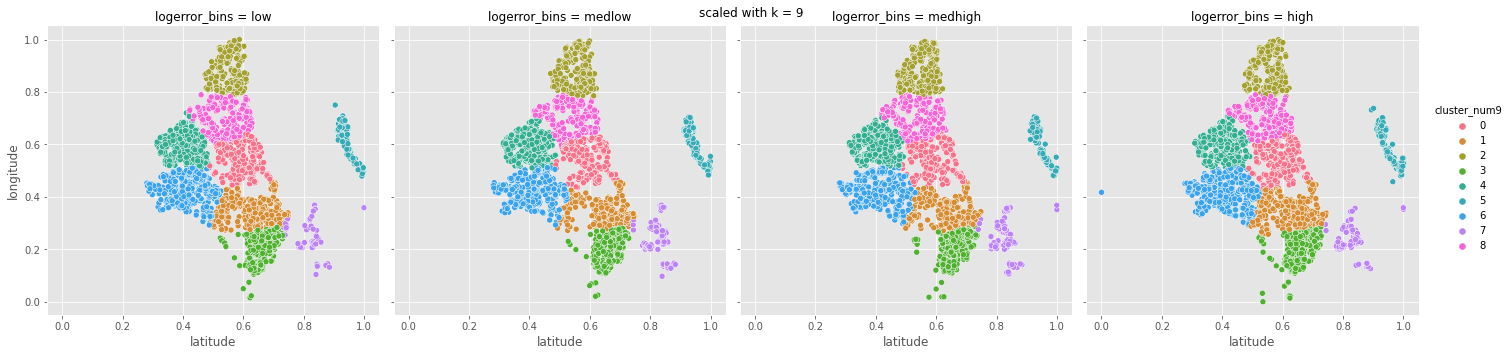

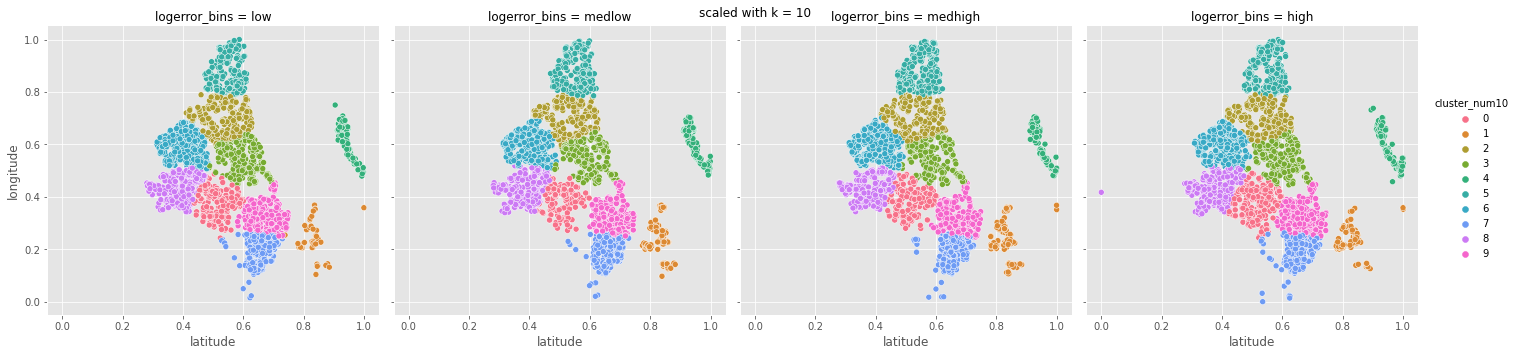

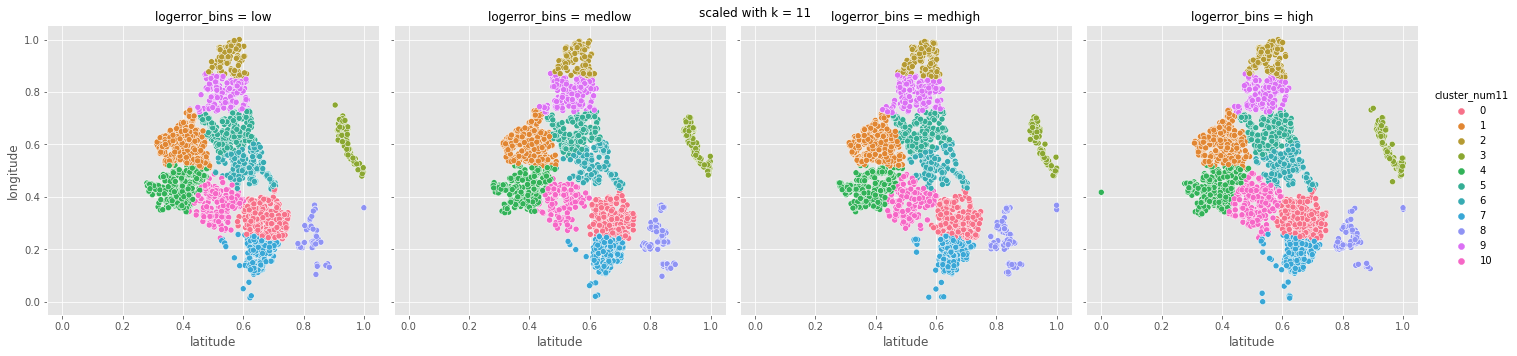

In [22]:
for k in range(2, 12):
    cluster(subset, k, k)

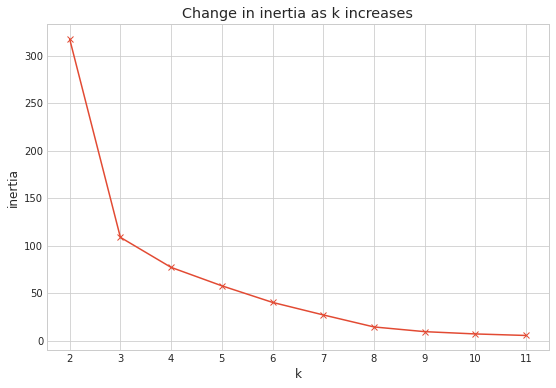

In [23]:
# lets determine a good k using a subset of x_train_scaled
subset = X_train_scaled[["bathroomcnt","bedroomcnt"]]
elbow_graph(subset)

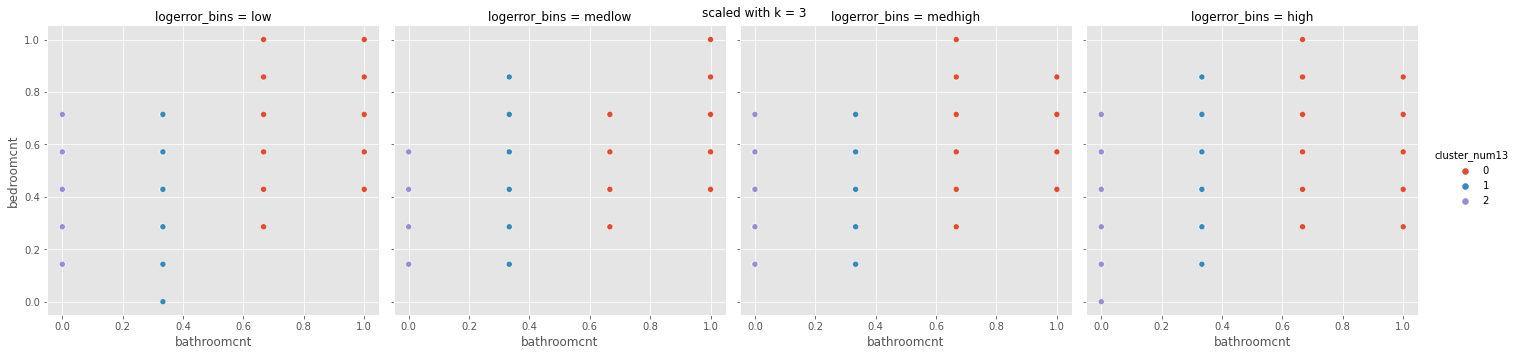

In [24]:
# use the k determined above
subset = X_train_scaled[["bathroomcnt","bedroomcnt"]]
cluster(subset, 3, 13)

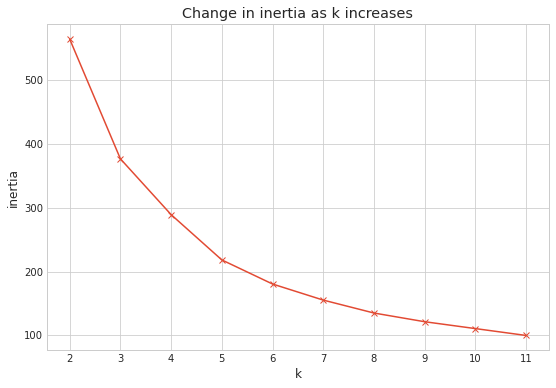

In [25]:
# lets determine a good k using a subset of x_train_scaled
subset = X_train_scaled[["taxvaluedollarcnt","age"]]
elbow_graph(subset)

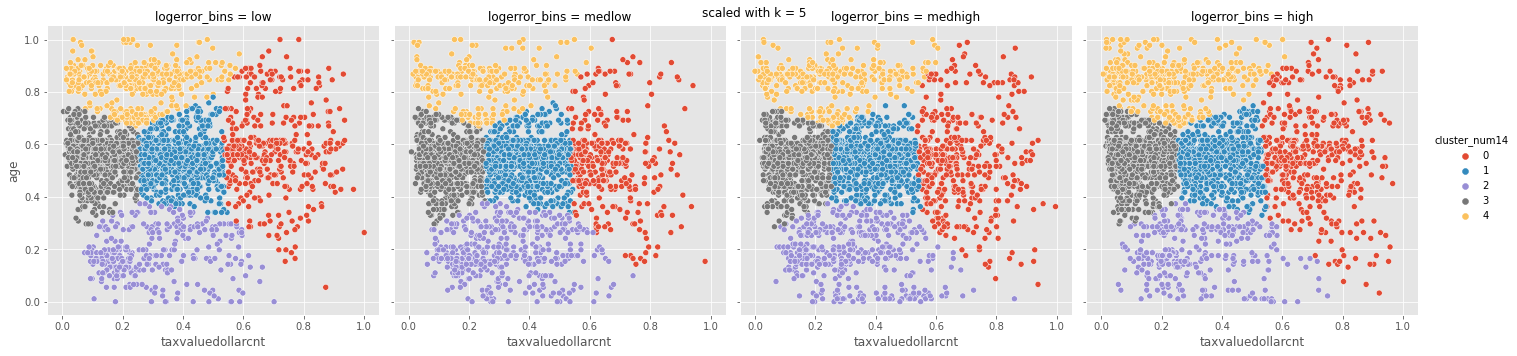

In [26]:
# use the k determined above
subset = X_train_scaled[["taxvaluedollarcnt","age"]]
cluster(subset, 5, 14)

looking at log error
1. Is there a correlation between log error and bathroom count?
2. Is there a correlation between log error and latitude?
3. Is there a correlation between log error and longitude?
4. Is there a correlation between log error and age?

1. Is there a correlation between log error and bathroom count?


<AxesSubplot:xlabel='bathroomcnt', ylabel='logerror'>

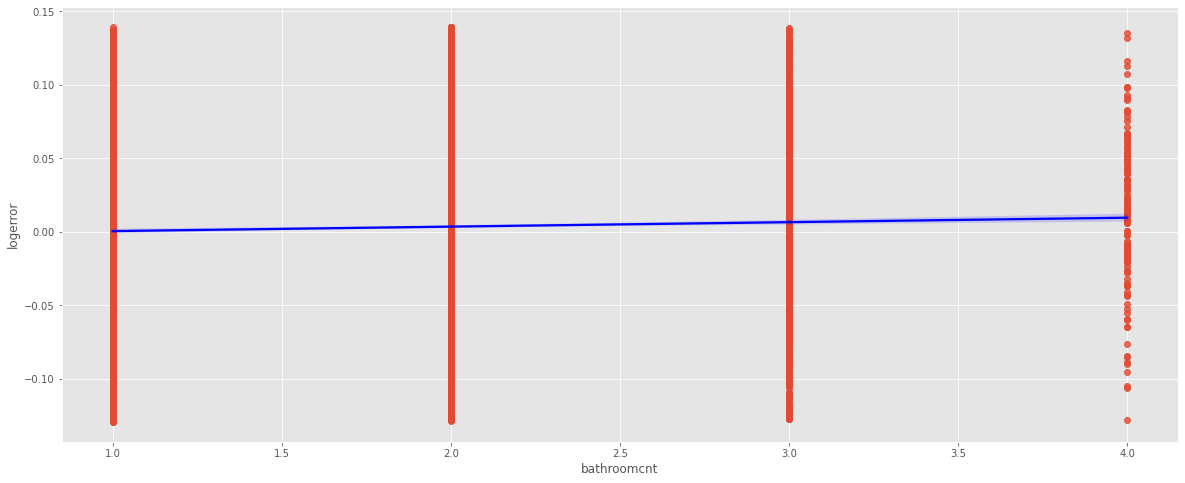

In [27]:
#plot correlation between logerror and bathroomcnt
sns.regplot(x="bathroomcnt", y="logerror", data=train, line_kws={"color": "blue"})



    Lets test this hypothesis

$H_0$ : There is no linear relationship between bathroomcnt and the logerror.
 
$H_A$ : There is a linear relationship between bathroomcnt and the logerror.

In [28]:
# stats test for logerror vs bathroomcnt
# alpha of 0.05 gives us 95% confidence interval
# can reject null if the p-value is less than 0.05
# since we are comparing two continuous variables, we can use the pearson R test
r, p = pearsonr(train['bathroomcnt'], train['logerror'])
r, p
# P-value is less than 0.05, so we reject null hypothesis


(0.04388565130306851, 3.9882978172649684e-06)

    Reject the null hypothesis and conclude that there is a linear relationship between bathroom and the value of the property.

~~$H_0$ : There is no linear relationship between bathroomcnt and the logerror.~~
 
$H_A$ : There is a linear relationship between bathroomcnt and the logerror.

2. Is there a correlation between log error and latitude?


<AxesSubplot:xlabel='latitude', ylabel='logerror'>

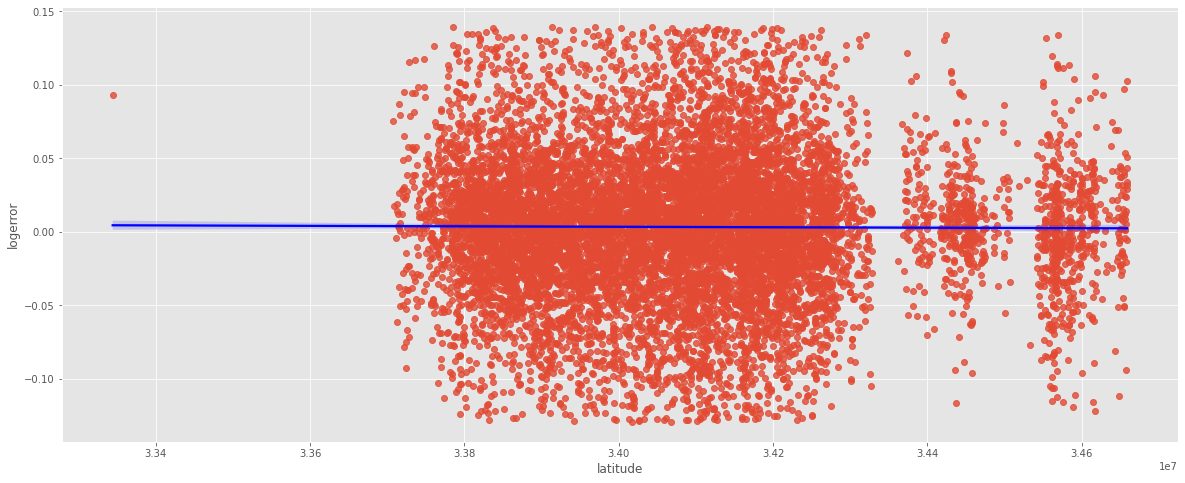

In [29]:
#plot correlation between logerror and bathroomcnt
sns.regplot(x="latitude", y="logerror", data=train, line_kws={"color": "blue"})


    Lets test this hypothesis

$H_0$ : There is no linear relationship between latitude and the logerror.
 
$H_A$ : There is a linear relationship between latitude and the logerror.

In [30]:
# stats test for logerror vs latitude
# alpha of 0.05 gives us 95% confidence interval
# can reject null if the p-value is less than 0.05
# since we are comparing two continuous variables, we can use the pearson R test
r, p = pearsonr(train['latitude'], train['logerror'])
r, p
# P-value is greater than 0.05, so we cannot reject null hypothesis

(-0.006406252627577998, 0.5009964816744279)

    Fail to reject the null hypothesis and conclude that there is a linear relationship between latitude and the value of the property.

$H_0$ : There is no linear relationship between latitude and the logerror.
 
~~$H_A$ : There is a linear relationship between latitude and the logerror.~~

3. Is there a correlation between log error and longitude?


<AxesSubplot:xlabel='longitude', ylabel='logerror'>

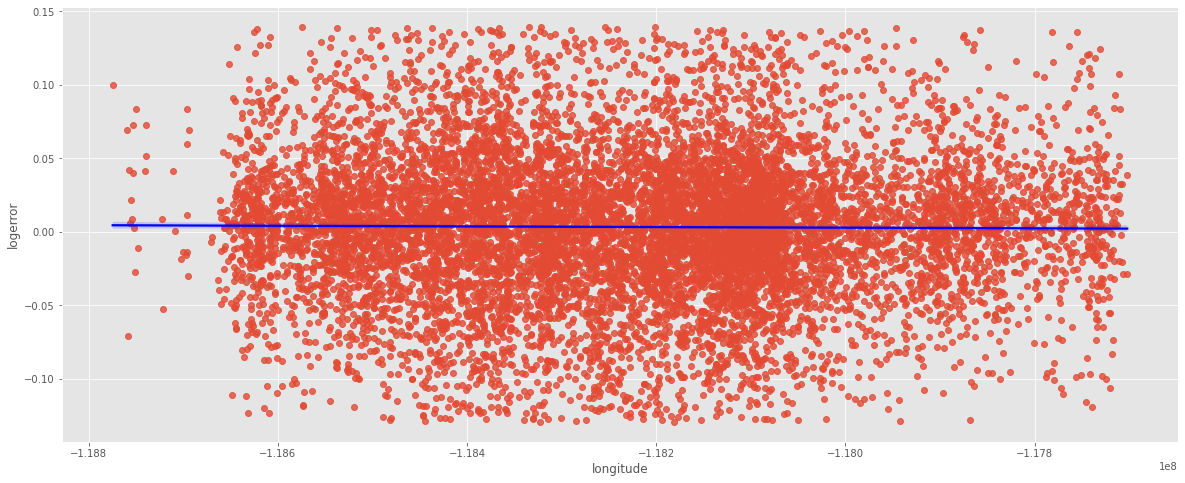

In [31]:
#plot correlation between logerror and longitude
sns.regplot(x="longitude", y="logerror", data=train, line_kws={"color": "blue"})


    Lets test this hypothesis

$H_0$ : There is no linear relationship between longitude and the logerror.
 
$H_A$ : There is a linear relationship between longitude and the logerror.

In [32]:
# stats test for logerror vs longitude
# alpha of 0.05 gives us 95% confidence interval
# can reject null if the p-value is less than 0.05
# since we are comparing two continuous variables, we can use the pearson R test
r, p = pearsonr(train['longitude'], train['logerror'])
r, p
# P-value is greater than 0.05, so we cannot reject null hypothesis

(-0.00969130041916129, 0.3086767015830554)

    Fail to reject the null hypothesis and conclude that there is a linear relationship between longitude and the value of the property.

$H_0$ : There is no linear relationship between longitude and the logerror.
 
~~$H_A$ : There is a linear relationship between longitude and the logerror.~~

4. Is there a correlation between log error and age?

<AxesSubplot:xlabel='age', ylabel='logerror'>

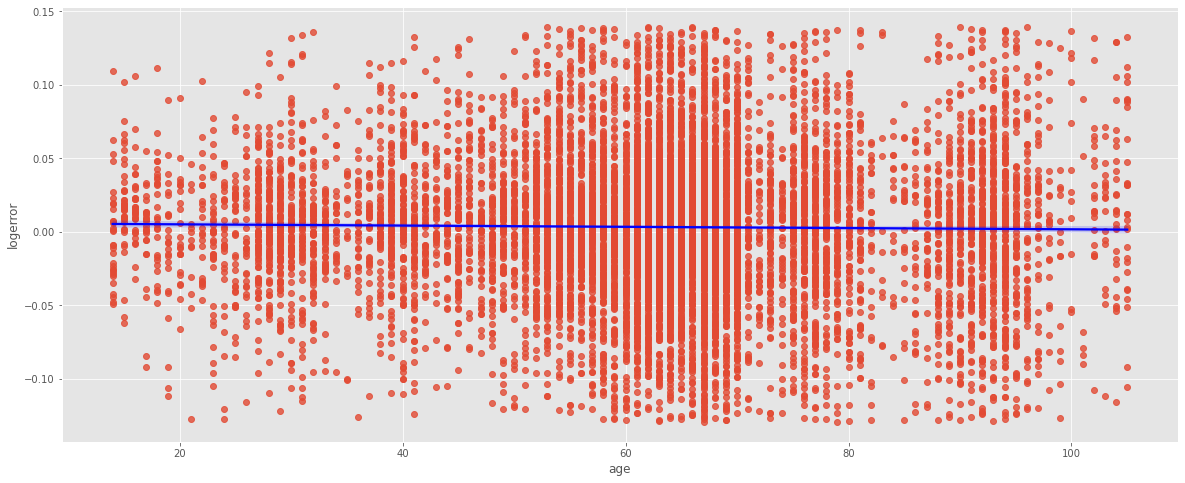

In [33]:
#plot correlation between logerror and age
sns.regplot(x="age", y="logerror", data=train, line_kws={"color": "blue"})

    Lets test this hypothesis

$H_0$ : There is no linear relationship between age and the logerror.
 
$H_A$ : There is a linear relationship between age and the logerror.

In [34]:
# stats test for logerror vs age
# alpha of 0.05 gives us 95% confidence interval
# can reject null if the p-value is less than 0.05
# since we are comparing two continuous variables, we can use the pearson R test
r, p = pearsonr(train['age'], train['logerror'])
r, p
# P-value is greater than 0.05, so we cannot reject null hypothesis

(-0.015185714839697316, 0.11066604930982041)

    Fail to reject the null hypothesis and conclude that there is a linear relationship between age and the value of the property.

$H_0$ : There is no linear relationship between age and the logerror.
 
~~$H_A$ : There is a linear relationship between age and the logerror.~~

In [35]:
baseline_train = evaluate.baseline_mean_errors(y_train)['RMSE']
baseline_validate = evaluate.baseline_mean_errors(y_validate)['RMSE']
baseline_train, baseline_validate

(0.049094962453643025, 0.04786374313790496)

In [36]:
baseline_train = evaluate.baseline_median_errors(y_train)['RMSE']
baseline_validate = evaluate.baseline_median_errors(y_validate)['RMSE']
baseline_train, baseline_validate

(0.0490983284766728, 0.04786819378301526)

Mean is better than median for baseline model


In [125]:
# build a dataframe to store rmse values
#results = pd.DataFrame(columns=['model_number','model_type','RMSE_train','RMSE_validate','baseline','better_than_baseline'])
results = pd.DataFrame()
baseline_model = pd.Series({'model_number':0,'model_type':'baseline','RMSE_train':baseline_train,'RMSE_validate':baseline_validate,'baseline':baseline_train,'better_than_baseline':False})
results = pd.concat([results, baseline_model],axis = 0)
results.T

model_number model_type RMSE_train RMSE_validate  baseline  \
0            0   baseline   0.049098      0.047868  0.049098   

  better_than_baseline  
0                False

In [38]:
def run_model(features, model_number):
    '''run a model and return the rmse'''
    # make and fit the model
    model = LinearRegression().fit(X_train_scaled[features], y_train)
    # make predictions
    y_train_pred = model.predict(X_train_scaled[features])
    y_validate_pred = model.predict(X_validate_scaled[features])
    # compute the RMSE
    rmse_train = mean_squared_error(y_train, y_train_pred)**(1/2)
    rmse_validate = mean_squared_error(y_validate, y_validate_pred)**(1/2)
    # add the rmse to the results dataframe
    model_results = pd.Series({'model_number':model_number,
        'model_type':'Linear Regression',
        'features':features,
        'RMSE_train':rmse_train,
        'RMSE_validate':rmse_validate,
        'baseline':baseline_train,
        'better_than_baseline':rmse_train<baseline_train})
    # return the results
    return model_results
    #results = pd.concat([results, model_results],axis = 1)

In [74]:
model_results = run_model(['bathroomcnt','bedroomcnt'], 1)
results = pd.concat([results, model_results],axis = 1)
# transpose it so each row is a model
results.T.reset_index(drop=True)

model_number         model_type RMSE_train RMSE_validate  baseline  \
0            0           baseline   0.049098      0.047868  0.049098   
1            1  Linear Regression   0.049035      0.047817  0.049098   

  better_than_baseline                   features  
0                False                        NaN  
1                 True  [bathroomcnt, bedroomcnt]

In [ ]:
# drop data leakage columns
X_train_scaled = X_train_scaled.drop(columns=['logerror_bins'])

In [76]:
def select_RFE(X, y, k=2):
    '''pick k features with the highest RFE score'''
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=k)
    rfe.fit(X, y)
    # return pd.DataFrame({'rfe_ranking': rfe.ranking_}, index=X_train.columns)
    return X.columns[rfe.get_support()]

In [77]:
# adjust the number of features to select, use those features, and run the model
for i in range(1,10):
    features = select_RFE(X_train_scaled, y_train, k=i).to_list()
    model_results = run_model(features, model_number= i+1)
    results = pd.concat([results, model_results],axis = 1)


In [87]:
results.T.reset_index(drop=True)

model_number         model_type RMSE_train RMSE_validate  baseline  \
0             0           baseline   0.049098      0.047868  0.049098   
1             1  Linear Regression   0.049035      0.047817  0.049098   
2             2  Linear Regression    0.04908      0.047904  0.049098   
3             3  Linear Regression   0.049079      0.047904  0.049098   
4             4  Linear Regression   0.049076      0.047908  0.049098   
5             5  Linear Regression   0.049075      0.047918  0.049098   
6             6  Linear Regression   0.048854      0.047814  0.049098   
7             7  Linear Regression   0.048849      0.047821  0.049098   
8             8  Linear Regression   0.048845      0.047821  0.049098   
9             9  Linear Regression   0.048845      0.047821  0.049098   
10           10  Linear Regression   0.048737      0.047661  0.049098   

   better_than_baseline                                           features  
0                 False                                                NaN  
1                  True                          [bathroomcnt, bedroomcnt]  
2                  True                                             [010G]  
3                  True                                       [010G, 0131]  
4                  True                [landtaxvaluedollarcnt, 010G, 0131]  
5                  True     [landtaxvaluedollarcnt, taxamount, 010G, 0131]  
6                  True  [calculatedfinishedsquarefeet, landtaxvaluedol...  
7                  True  [calculatedfinishedsquarefeet, landtaxvaluedol...  
8                  True  [calculatedfinishedsquarefeet, landtaxvaluedol...  
9                  True  [calculatedfinishedsquarefeet, landtaxvaluedol...  
10                 True  [calculatedfinishedsquarefeet, landtaxvaluedol...

In [44]:
clusters = ['cluster_num1', 'cluster_num2', 'cluster_num3', 'cluster_num4',
       'cluster_num5', 'cluster_num6', 'cluster_num7', 'cluster_num8',
       'cluster_num9', 'cluster_num10', 'cluster_num11', 'cluster_num13',
       'cluster_num14']

In [88]:
# run the models again, but this time with 1 cluster added
model_num =11
for i in range(len(clusters)):
    cluster = clusters[i]
    for j in range(1,10):
        features = select_RFE(X_train_scaled, y_train, k=j).to_list()
        features.append(cluster)
        model_results = run_model(features, model_number= model_num)
        results = pd.concat([results, model_results],axis = 1)
        model_num += 1



In [89]:
# results transposed to be easier to read
results2 = results.T.reset_index(drop=True)
# sort by rmse_validate
results2.sort_values(by=['RMSE_validate'], inplace=True)
results2

model_number         model_type RMSE_train RMSE_validate  baseline  \
46            46  Linear Regression    0.04871      0.047588  0.049098   
64            64  Linear Regression   0.048711      0.047605  0.049098   
19            19  Linear Regression   0.048728       0.04763  0.049098   
37            37  Linear Regression    0.04872      0.047632  0.049098   
73            73  Linear Regression   0.048734      0.047645  0.049098   
..           ...                ...        ...           ...       ...   
122          122  Linear Regression   0.049075      0.047918  0.049098   
5              5  Linear Regression   0.049075      0.047918  0.049098   
95            95  Linear Regression   0.049075      0.047919  0.049098   
104          104  Linear Regression   0.049068      0.047922  0.049098   
77            77  Linear Regression   0.049071      0.047923  0.049098   

    better_than_baseline                                           features  
46                  True  [calculatedfinishedsquarefeet, landtaxvaluedol...  
64                  True  [calculatedfinishedsquarefeet, landtaxvaluedol...  
19                  True  [calculatedfinishedsquarefeet, landtaxvaluedol...  
37                  True  [calculatedfinishedsquarefeet, landtaxvaluedol...  
73                  True  [calculatedfinishedsquarefeet, landtaxvaluedol...  
..                   ...                                                ...  
122                 True  [landtaxvaluedollarcnt, taxamount, 010G, 0131,...  
5                   True     [landtaxvaluedollarcnt, taxamount, 010G, 0131]  
95                  True  [landtaxvaluedollarcnt, taxamount, 010G, 0131,...  
104                 True  [landtaxvaluedollarcnt, taxamount, 010G, 0131,...  
77                  True  [landtaxvaluedollarcnt, taxamount, 010G, 0131,...  

[128 rows x 7 columns]

In [60]:
# look at features for model number 46
best_features = results2.loc[46, 'features']
best_features


['calculatedfinishedsquarefeet',
 'landtaxvaluedollarcnt',
 'taxamount',
 '0101',
 '0102',
 '0108',
 '010G',
 '010M',
 '0131',
 'cluster_num4']

In [64]:
# run model 46 on baseline
# rebuild the best model
model = LinearRegression()
#convert list to array to pass into function
features = best_features
#fit on the combination determined above
model.fit(X_train_scaled[features], y_train)
# make predictions
y_train_pred = model.predict(X_train_scaled[features])
y_validate_pred = model.predict(X_validate_scaled[features])
y_test_pred = model.predict(X_test_scaled[features])
# compute the RMSE
rmse_train = mean_squared_error(y_train, y_train_pred)**(1/2)
rmse_validate = mean_squared_error(y_validate, y_validate_pred)**(1/2)
rmse_test = mean_squared_error(y_test, y_test_pred)**(1/2)
#build df
stats = pd.Series({"model_number": 46,
    "model_type": 'LinearRegression',
    "number_of_features": len(features),
    "RMSE_train": rmse_train,
    "RMSE_validate": rmse_validate,
    "RMSE_test": rmse_test,
    "baseline": baseline_train,
    "better_than_baseline": rmse_train<baseline_train})

#show the results of the best model
stats



model_number                          46
model_type              LinearRegression
number_of_features                    10
RMSE_train                       0.04871
RMSE_validate                   0.047588
RMSE_test                       0.047793
baseline                        0.049098
better_than_baseline                True
dtype: object

In [112]:
def run_model2(features, model_number):
    '''run a model and return the rmse'''
    # make and fit the model
    model = LinearRegression().fit(train_subset[features], y_train[train_subset.index])
    # make predictions
    y_train_pred = model.predict(train_subset[features])
    y_validate_pred = model.predict(validate_subset[features])
    # compute the RMSE
    rmse_train = mean_squared_error(y_train[train_subset.index], y_train_pred)**(1/2)
    rmse_validate = mean_squared_error(y_validate[validate_subset.index], y_validate_pred)**(1/2)
    # add the rmse to the results dataframe
    model_results = pd.Series({'model_number':model_number,
        'model_type':'Linear Regression',
        'features':features,
        'RMSE_train':rmse_train,
        'RMSE_validate':rmse_validate,
        'baseline':baseline_train,
        'better_than_baseline':rmse_train<baseline_train})
    # return the results
    return model_results
    #results = pd.concat([results, model_results],axis = 1)

In [127]:
# run the models again, but this time with 1 cluster added
model_num =1
for i in range(4):
    train_subset = X_train_scaled[X_train_scaled.cluster_num4 == i]
    validate_subset = X_validate_scaled[X_validate_scaled.cluster_num4 == i]
    for j in range(1,10):
        features = select_RFE(train_subset, y_train[train_subset.index], k=j).to_list()
        model_results = run_model2(features, model_number= model_num)
        results = pd.concat([results, model_results],axis = 1)
    model_num += 1

In [134]:
# results transposed to be easier to read
results2 = results.T.reset_index(drop=True)
# sort by rmse_validate
results2.sort_values(by=['RMSE_validate'], inplace=True)
results2
results3 = results2.groupby('model_number').min()
results3.groupby('model_type').mean()

RMSE_train  RMSE_validate  baseline  better_than_baseline
model_type                                                                  
Linear Regression    0.046913       0.046550  0.049098                  0.75
baseline             0.049098       0.047868  0.049098                  0.00